<a href="https://colab.research.google.com/github/austinpeel/jax-strong-lensing/blob/dev-egor/GRF_phase_averaged_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Folder='/content/drive/My Drive/Jax_Strong_Lensing/'

import sys
sys.path.append(Folder+'/Modules')
_=!python drive/My\ Drive/Jax_Strong_Lensing/Modules/My_repo/setup.py install

Mounted at /content/drive


In [2]:
_=!pip install pyFFTW
_=!pip install powerbox

In [3]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

#Jaxtronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer

#My utils
from jaxtronomy.GaussianRandomField.GRF_model import Potential_based_GRF_perturbed_lens
from jaxtronomy.GaussianRandomField.GRF_model import GRF_perturbed_lens
from jaxtronomy.GaussianRandomField.Lens_Source_model import Lens_Source_model

#GRF generator
import powerbox as pbox

# Universal font size
FS = 18

# Theory

Assume that we have GRF perturbed strong lensing event. First, we want to model it without GRF perturbations and consider the residuals.

## Data

observed data: $\psi(\vec{p}_{0})+\delta \psi(A_{0},\beta_{0},\phi_{0})$  
model 1: $\psi(\vec{p_1})$  
$res_{0}=Image(\delta \psi(A_{0},\beta_{0},\phi_{0})+\psi(\vec{p}_{0}))-Image(\psi(\vec{p_1}))$

,where $\vec{p}$ is a set of source light and unperturbed lens mass parameters and $A_{0},\beta_{0},\phi_{0}$ are correpsondingly amplitude,power slope and phase realisation of GRF power spectrum. Index 0 would refer to true values or zeroth aproximation.

## Model

simulated data: $\psi(\vec{p}_{1})+\delta \psi(A^{i},\beta^{j},\phi^{m})$  
model 2: $\psi(\vec{p_2})$  
$res^{i,j,m}=Image(\delta \psi(A^{i},\beta^{j},\phi^{m})+\psi(\vec{p}_{1}))-Image(\psi(\vec{p_2}))$

,where we assume that $\psi(\vec{p}_{1})$ is close to $\psi(\vec{p}_{0})$, and try to pick a realisation of GRF perturbation $\delta \psi(A^{i},\beta^{j},\phi^{m})$

## Power spectra and Loss function

Since Gaussian Random Field is defined by its Power Spectrum  
$PS\{\delta \psi(A_{0},\beta_{0},\phi_{0})\}=|FFT\{\delta \psi(A_{0},\beta_{0},\phi_{0})\}|^{2}=A_0 \cdot k^{-\beta_0}$

We further want to create loss in terms of residuals power spectra.
The problem here is that a particular realisation of phase $\phi_0$ is a big array that we don't want to fit. Rather we would take M realisations of phase $\phi_m$ and average the corresponding power spectra over phase realisations. In this case we concern ourselves only with interesting parameters $A_i$ and $\beta_j$ by excluding phase $\phi_m$ out of the equations.

In this case the loss function would be as follows:
$\mathcal{L}^{ij}=|| \ PS\{res_{0}\} - <PS\{res^{i,j,m}\}>_m \ ||$

## Model absorbtion function

Of course some effect of $\delta \psi(A_{0},\beta_{0},\phi_{0})$ would be absorbed into $\psi(\vec{p_1})$ as well as some effect of $\delta \psi(A^{i},\beta^{j},\phi^{m})$ would be absorbed into $\psi(\vec{p_2})$. To work with this absorbtion we can introduce model absorbtion function:  

$\vec{p_1}=f(\vec{p},A_{0},\beta_{0},\phi_{0})$  
$\vec{p_2}=f(f(\vec{p},A_{0},\beta_{0},\phi_{0}),A^{i},\beta^{j},\phi^{m})$








## Hypotheses




### 1) weak dependence of model absorbtion function on phase $\phi^{m}$

One of the assumptions to be made is that model parameters aggravation should mostly depend on GRF's amplitude $A$ and power slope $\beta$, rather than on phase realisation $\phi$. So we say that impact of phase is small. Let's denote it as:

$\vec{p_1}=f(\vec{p},A_{0},\beta_{0}) + \delta f(\phi_{0})$   
$\vec{p_2}=f(f(\vec{p},A_{0},\beta_{0}) +\delta f(\phi_{0}),A^{i},\beta^{j})+ \delta f(\phi^{m})$




### 2)Big enough number M of phase realisations $\phi^{m}$

Now we can write our mock residual power spectrum in terms of model absorbtion functions.

$PS\{res^{i,j,m}\}=PS\{ \delta \psi(A^{i},\beta^{j},\phi^{m})+\psi(\vec{p}_{1})-\psi(\vec{p_2})  \}= \\
PS\{ \delta \psi(A^{i},\beta^{j},\phi^{m})+\psi(f(\vec{p},A_{0},\beta_{0}) + \delta f(\phi_{0}))-\psi(f(f(\vec{p},A_{0},\beta_{0}) +\delta f(\phi_{0}),A^{i},\beta^{j})+ \delta f(\phi^{m}))  \}$

Now if all $\delta f(\phi)$ would be eliminated, the formula would become quite useful. So the second assumption is that the number of phase realisations **M** is enough for the phase averaged power spectrum to not depend on the actual phases realisations, in other words that

$M: \quad  <PS\{res^{i,j,m}\}>_{m \in [0,M]} \quad \approx  \quad <PS\{res^{i,j,m}\}>_{m \in [0,\infty]}$

In that case the loss function can be represented as 

$\mathcal{L}^{ij}=|| \ PS[A_0,\beta_0,\vec{p},f(\vec{p},A_{0},\beta_{0})] - PS[A_0,\beta_0,f(\vec{p},A_{0},\beta_{0}),f(f(\vec{p},A_{0},\beta_{0}),A^{i},\beta^{j})] \ ||$

If we assume that the fitted values are close to the true onse we can expect the loss function to be 

$\mathcal{L}^{ij}=|| \ O[A_0 - A^i] + O[\beta_0 -\beta^j] + O[\vec{p}-f(\vec{p},A_{0},\beta_{0})]+ O[f(\vec{p},A_{0},\beta_{0})-f(f(\vec{p},A_{0},\beta_{0}),A^{i},\beta^{j})] \ ||+...$

The assumption that the fitted values are close to the true ones if GRF impact on the system is very small. In other words, if we work in perturbation theory

$\mathcal{L}^{ij}=|| \  O[A_0 - A^i] + O[\beta_0 -\beta^j] + O[\frac{\delta \psi(A_{0},\beta_{0},\phi_{0})}{\psi(\vec{p})}]+ O[\frac{\delta \psi(A^{i},\beta^{j},\phi^{m})}{\psi(\vec{p_1})}] \ ||+...$




### 3) Convergence of $\mathcal{L}^{ij}$ forces convergence of $A^i \rightarrow A_0, \beta^j \rightarrow \beta_0$

consider convergence loss and model absorbtion loss  
$\mathcal{L}_{conv}=|| \  O[A_0 - A^i] + O[\beta_0 -\beta^j] \ ||$  
$\mathcal{L}_{abs}=|| \  O[\frac{\delta \psi(A_{0},\beta_{0},\phi_{0})}{\psi(\vec{p})}]+ O[\frac{\delta \psi(A^{i},\beta^{j},\phi^{m})}{\psi(\vec{p_1})}] \ ||$

So here we want to find that either absorbtion loss is neglegible
$\mathcal{L}_{conv} \gg \mathcal{L}_{abs}$  
or that both losses converge simultaniously  
$\mathcal{L}^{ij} \rightarrow 0$ => $\mathcal{L}_{conv}^2 + \mathcal{L}_{abs}^2 \rightarrow 0 $






# Simulation parameters, fitting and spectrum-related functions

In [4]:
kwargs_lens_mass_array=[{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                       {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}]

kwargs_source_light_array=[{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]


#Number of phases realisations
M=10

#Class for GRF hadnling
GRF_class=Potential_based_GRF_perturbed_lens(kwargs_lens_mass_array=kwargs_lens_mass_array,\
                                             kwargs_source_light_array=kwargs_source_light_array)

WARNING! sigma_b*f 0 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.


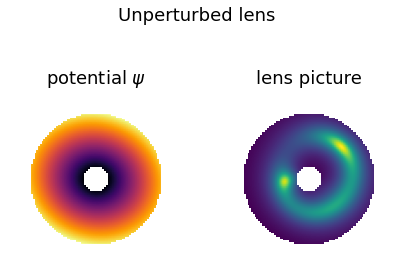

In [5]:
#Data grid
pixel_grid = PixelGrid(**GRF_class.Lens_Source_model.kwargs_pixel)
pix_scl=GRF_class.Lens_Source_model.kwargs_pixel['transform_pix2angle'][0][0]
xgrid, ygrid = pixel_grid.pixel_coordinates


#Since SIE characterisitics diverge in the center we compute everything in the masked region
# Generate a mask
rmin = 0.5
rmax = 3
# High-res grid
radius = np.hypot(xgrid, ygrid)
mask = ((radius >= rmin) & (radius <= rmax)).astype(bool)
min_mask_freq=1/(rmax-rmin)

#Account for variance only in the masked region impacting the source's light
unperturbed_potential=deepcopy(np.array(GRF_class.get_total_potential(include_GRF=False)))
unperturbed_potential[~mask]=np.nan
unpert_potential_variance=np.nanstd(unperturbed_potential)**2

lens_picture=np.where(mask,GRF_class.get_lens_picture(picture_type='model',include_GRF=False),np.nan)

fig,ax=plt.subplots(1,2,figsize=(7,5))
ax[0].imshow(unperturbed_potential,cmap='inferno', origin='lower')
ax[1].imshow(lens_picture,origin='lower')

unpert_fig_titles=[r"potential $\psi$",'lens picture']
for i in range(2):
  ax[i].axis('off')
  ax[i].set_title(unpert_fig_titles[i], fontsize=FS)

fig.suptitle('Unperturbed lens',fontsize=FS)
plt.show()

In [6]:
  psf = PSF(**GRF_class.Lens_Source_model.kwargs_psf)

  noise = Noise(GRF_class.Lens_Source_model.kwargs_pixel['nx'], GRF_class.Lens_Source_model.kwargs_pixel['ny'], **GRF_class.Lens_Source_model.kwargs_noise)

  # Generate a lensed image based on source and lens models
  #Source light from simulation
  #Lens mass except for PIXELATED GRF from simulation
  lens_image = LensImage(data_class=PixelGrid(**GRF_class.Lens_Source_model.kwargs_pixel),
                         psf_class=psf,
                         noise_class=noise,
                         lens_model_class=LensModel(GRF_class.Lens_Source_model.lens_mass_model_list[:-1]),
                         source_model_class=LightModel(GRF_class.Lens_Source_model.source_light_model_list),
                         lens_light_model_class=LightModel([]),
                         kwargs_numerics={'supersampling_factor': 1})
  
  #To calculate noise map for the first time
  _= lens_image.simulation(compute_true_noise_map=True,
                             kwargs_lens=list(GRF_class.Lens_Source_model.kwargs_lens_mass[:-1]),
                             kwargs_source=list(GRF_class.Lens_Source_model.kwargs_source_light),
                             kwargs_lens_light=[{}])

In [69]:
def get_model(Lens_Source_model):

  psf = PSF(**GRF_class.Lens_Source_model.kwargs_psf)

  noise = Noise(Lens_Source_model.kwargs_pixel['nx'], Lens_Source_model.kwargs_pixel['ny'], **GRF_class.Lens_Source_model.kwargs_noise)

  # Generate a lensed image based on source and lens models
  #Source light from simulation
  #Lens mass except for PIXELATED GRF from simulation
  lens_image = LensImage(data_class=PixelGrid(**Lens_Source_model.kwargs_pixel),
                         psf_class=psf,
                         noise_class=noise,
                         lens_model_class=LensModel(Lens_Source_model.lens_mass_model_list[:-1]),
                         source_model_class=LightModel(Lens_Source_model.source_light_model_list),
                         lens_light_model_class=LightModel([]),
                         kwargs_numerics={'supersampling_factor': 1})
  
  #To calculate noise map for the first time
  _= lens_image.simulation(compute_true_noise_map=True,
                             kwargs_lens=list(Lens_Source_model.kwargs_lens_mass[:-1]),
                             kwargs_source=list(Lens_Source_model.kwargs_source_light),
                             kwargs_lens_light=[{}])


  kwargs_true = {'kwargs_lens': list(Lens_Source_model.kwargs_lens_mass[:-1]), 'kwargs_source': list(Lens_Source_model.kwargs_source_light)}

  return lens_image,kwargs_true

def get_parameters(Lens_Source_model):

  kwargs_model = {
    'lens_model_list': Lens_Source_model.lens_mass_model_list[:-1],
    'source_model_list': Lens_Source_model.source_light_model_list,
    'lens_light_model_list': [],
  }

  kwargs_init = {
    'kwargs_lens': [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},{'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}],
    'kwargs_source': [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}],
  }


  #Priors from this article Park et al. 2021 Table 1 (Partially)
  '''
  kwargs_prior = {
    'kwargs_lens': [{'theta_E': ['gaussian', 1.1, 0.1], 'e1': ['gaussian', 0, 0.2], 'e2': ['gaussian', 0, 0.2], \
                     'center_x': ['gaussian', 0, 0.07], 'center_y': ['gaussian', 0, 0.07]}, {'gamma1': ['uniform', -0.05, 0.05], 'gamma2': ['uniform', -0.05, 0.05]}],
                  
    'kwargs_source': [{'amp': ['uniform',5.0,20.0], 'R_sersic': ['uniform',1e-3,5.], 'n_sersic': ['gaussian',3,0.5],\
                       'center_x': ['uniform', -1.0, 1.0], 'center_y': ['uniform', -1.0, 1.0],'e1': ['gaussian', 0, 0.2], 'e2': ['gaussian', 0, 0.2]}],
  }
  '''

  kwargs_prior = {
    'kwargs_lens': [{'theta_E': ['uniform', 1., 2.], 'e1': ['gaussian', 0, 0.2], 'e2': ['gaussian', 0, 0.2], \
                     'center_x': ['gaussian', 0, 0.102], 'center_y': ['gaussian', 0, 0.102]}, {'gamma1': ['uniform', -0.5, 0.5], 'gamma2': ['uniform', -0.5, 0.5]}],
                  
    'kwargs_source': [{'amp': ['uniform',5.0,20.0], 'R_sersic': ['uniform',1e-3,5.], 'n_sersic': ['uniform',1e-3,4.0],\
                       'center_x': ['uniform', -1.0, 1.0], 'center_y': ['uniform', -1.0, 1.0],'e1': ['gaussian', 0, 0.2], 'e2': ['gaussian', 0, 0.2]}],
  }
  
  kwargs_fixed = {
    'kwargs_lens': [{}, {'ra_0': 0., 'dec_0': 0.}],  # fix origin of the external shear profile
    'kwargs_source': [{}],  # fix all source parameters
    }

  parameters = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)

  return parameters


def fit_data(data,lens_image,parameters):

  loss = Loss(data, lens_image, parameters)
  grad_loss = jax.jit(jax.grad(loss))

  optimizer = Optimizer(loss, parameters)
  #BFGS for gradient only, Newton-CG for graident+ hessian vector product
  #BFGS is faster since it doesn't compute hessian vp
  best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method='BFGS', restart_from_init=True,
                         use_exact_hessian_if_allowed=False)
    
  kwargs_final = deepcopy(parameters.ML_values(as_kwargs=True))
  if extra_fields['hess_inv'] is not None:
    fisher_matrix = extra_fields['hess_inv']
  else:
    hess_ml = optimizer.hessian(best_fit)
    fisher_matrix = jax.numpy.linalg.inv(hess_ml)

  return kwargs_final,fisher_matrix

def get_fit_kwargs_row(lensing_class,potential_perturbed_data,Potential_beta_array,Variance_index):
    lens_image,kwargs_true=get_model(lensing_class)
    parameters=get_parameters(fix_lens_origin=False)
    num_of_params=len(parameters.kwargs2args(kwargs_true))


    kwargs_final_row=[]
    fisher_matrices=np.zeros((len(Potential_beta_array),num_of_params,num_of_params))
    for j,beta in enumerate(Potential_beta_array):
        parameters=get_parameters(fix_lens_origin=False)
        data=potential_perturbed_data[Variance_index,j]

        kwargs_final,fisher_matrix=fit_data(data,lens_image,parameters)
        fisher_matrices[j]=fisher_matrix

        kwargs_final_row+=[kwargs_final]
    
    return np.array(kwargs_final_row),fisher_matrices

def save_row(lensing_class,potential_perturbed_data,Potential_beta_array,Variance_index):
    kwargs_final_row,fisher_matrices=get_fit_kwargs_row(lensing_class,potential_perturbed_data,Potential_beta_array,Variance_index)
    np.save(Folder+'/Data/16x16/Separate_fitting/Kwargs_row_source_lens_%d.npy'%Variance_index,kwargs_final_row)
    np.save(Folder+'/Data/16x16/Separate_fitting/Fisher_matrices_%d.npy'%Variance_index,fisher_matrices)

def Radial_profile(image,q=1,x0=None,y0=None,phi=0):
    if x0 is None or y0 is None:
        x0=image.shape[1]/2
        y0=image.shape[0]/2


    R_max=np.min(image.shape)//2
    radial_profile=np.zeros(R_max)
    counter=np.zeros(R_max)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            R=np.sqrt(np.power((x-x0)*np.cos(phi)+(y-y0)*np.sin(phi),2)+
                np.power((y-y0)*np.cos(phi)-(x-x0)*np.sin(phi),2)/np.power(q,2))
            #Account only unmasked values 
            if (R<R_max):
                radial_profile[int(R)]+=image[y,x]
                counter[int(R)]+=1

    mask_nan=(counter==0)
    counter[mask_nan]=np.nan
    radial_profile=radial_profile/counter
    #radial_profile[mask_nan]=0

    #Radial profile is average Flux in a ring of radius R
    return radial_profile

def compute_radial_spetrum(image,pix_scl=pix_scl,mask=mask,min_mask_freq=min_mask_freq):
  masked_image=np.where(mask,image,0)
  spectrum=np.fft.fft2(masked_image)
  half_im_size=image.shape[0]//2
  Centered_Spectrum=np.roll(np.abs(spectrum)**2,half_im_size,axis=(0,1))
  k=np.fft.fftshift(np.fft.fftfreq(image.shape[0],pix_scl))
  kx,ky=np.meshgrid(k,k)
  k_abs=np.sqrt(kx**2+ky**2)
  
  #Since mask outlines a ring from rmin to rmax the span of frequncies is limited by 1/(rmax-rmin)
  Centered_Spectrum_corr=np.where(k_abs>min_mask_freq,Centered_Spectrum,np.nan)

  return k[half_im_size:],Radial_profile(Centered_Spectrum_corr)

In [8]:
'''#Create grid of GRF variances and power slopes that aggravate lens with same strength in terms of variance 
def potential_Var_from_residual_Var(residual_variance,beta_array,df_coef):
  q=df_coef.loc['potential_logvariance','Residual coefs']
  p=df_coef.loc['beta','Residual coefs']
  C=df_coef.loc['bias','Residual coefs']
  logVariance=(np.log10(residual_variance)-p*beta_array-C)/q
  return np.power(10,logVariance)

#Relation between impact of GRF on lens, GRF variance and power slope
df_coef=pd.DataFrame(data=[0.,1.0020,-0.2656],index=['bias','potential_logvariance','beta'],columns=['Residual coefs'])
unperturbed_lens_variance=GRF_class.get_lens_picture(picture_type='model').std()**2

Potential_beta_array=np.linspace(2,7,16)


Potential_variance_array=np.zeros(len(Potential_beta_array))
#Lens aggravation image variance is 0.005 of actual lens image variance

for j in enumerate(Potential_beta_array):
  Potential_variance_array=potential_Var_from_residual_Var(np.power(10,-2.5)*unperturbed_lens_variance,Potential_beta_array,df_coef=df_coef)

perturbed_lens_images=np.zeros((len(Potential_variance_array),GRF_class.Lens_Source_model.kwargs_pixel['nx'],GRF_class.Lens_Source_model.kwargs_pixel['ny']))

for i,Variance in enumerate(Potential_variance_array):
  GRF_class.Change_Power_Spectrum(Variance=Potential_variance_array[0],Power_slope=Potential_beta_array[i])
  perturbed_lens_images[i]=GRF_class.get_lens_picture(picture_type='model')


GRF_impact_images=perturbed_lens_images-GRF_class.get_lens_picture(picture_type='model',include_GRF=False)

fig,ax=plt.subplots(2,len(Potential_beta_array),figsize=(30,6))

for i,beta in enumerate(Potential_beta_array):
  img_pert=ax[0,i].imshow(perturbed_lens_images[i],origin='lower',vmin=perturbed_lens_images.min(),vmax=perturbed_lens_images.max())
  #Lens with GRF - Lens without GRF = GRF impact
  img_impact=ax[1,i].imshow(GRF_impact_images[i],origin='lower',cmap='seismic',vmin=GRF_impact_images.min(),vmax=GRF_impact_images.max())
  ax[0,i].set_title(r'$\beta=$'+'{:.1f}'.format(beta))
  ax[1,i].set_xlabel('log(Var_ratio)={:.1f}'.format(np.log10((GRF_impact_images[i].std()**2)/(perturbed_lens_images[i].std()**2))))
  ax[0,i].set_xticks([])
  ax[0,i].set_yticks([])
  ax[1,i].set_xticks([])
  ax[1,i].set_yticks([])


ax[0,0].set_ylabel('Perturbed \n Lens')
ax[1,0].set_ylabel('GRF \n Impact')

fig.tight_layout()
plt.show()'''

"#Create grid of GRF variances and power slopes that aggravate lens with same strength in terms of variance \ndef potential_Var_from_residual_Var(residual_variance,beta_array,df_coef):\n  q=df_coef.loc['potential_logvariance','Residual coefs']\n  p=df_coef.loc['beta','Residual coefs']\n  C=df_coef.loc['bias','Residual coefs']\n  logVariance=(np.log10(residual_variance)-p*beta_array-C)/q\n  return np.power(10,logVariance)\n\n#Relation between impact of GRF on lens, GRF variance and power slope\ndf_coef=pd.DataFrame(data=[0.,1.0020,-0.2656],index=['bias','potential_logvariance','beta'],columns=['Residual coefs'])\nunperturbed_lens_variance=GRF_class.get_lens_picture(picture_type='model').std()**2\n\nPotential_beta_array=np.linspace(2,7,16)\n\n\nPotential_variance_array=np.zeros(len(Potential_beta_array))\n#Lens aggravation image variance is 0.005 of actual lens image variance\n\nfor j in enumerate(Potential_beta_array):\n  Potential_variance_array=potential_Var_from_residual_Var(np.power

# Search for proper phase realisations number M

## Create data for different scales $\psi(\vec{p_0})+\delta \psi(A_{0},\beta_{0},\phi_{0})$  

In [9]:
#Pick different Variances so the GRF impact is of the same order of magnitude
GRF_Variances=[1e-5,1e-4]
Betas=[2,7]


#The seed for data GRF generation.
#Pick one that we for sure won't face in mock GRFs grid
data_random_seed=2**32 - 1
#Smooth data will have default kwargs
data=np.zeros((2,GRF_class.Lens_Source_model.kwargs_pixel['nx'],GRF_class.Lens_Source_model.kwargs_pixel['ny']))
data_smooth=np.zeros_like(data)

GRF_class.Lens_Source_model.random_seed=data_random_seed

for i in range(2):
  GRF_class.Change_Power_Spectrum(Variance=GRF_Variances[i],Power_slope=Betas[i])
  #For now we neglect noise and psf
  data[i]=GRF_class.get_lens_picture(picture_type='model')
  data_smooth[i]=GRF_class.get_lens_picture(picture_type='model',include_GRF=False)

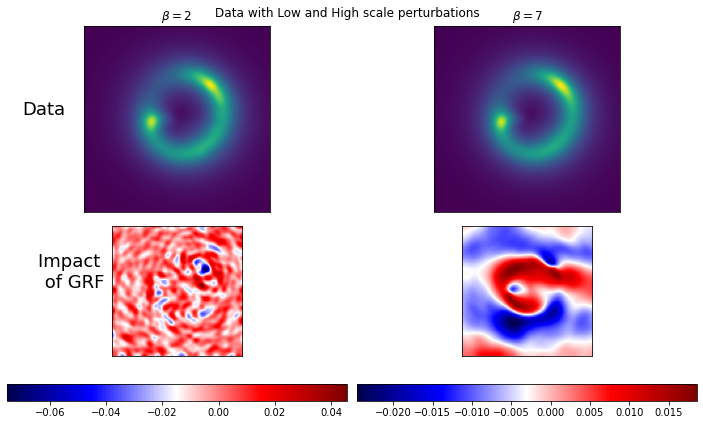

In [10]:
fig,ax=plt.subplots(2,2,figsize=(10,6))

#Data
for i in range(2):
  ax[0,i].imshow(data[i],origin='lower')
  ax[0,i].set_title(r'$\beta=$'+'{:.0f}'.format(Betas[i]))

ax[0,0].set_ylabel('Data',rotation=0.,labelpad=40,fontsize=FS)

#Impact of GRF
for i in range(2):
  im=ax[1,i].imshow((data[i]-data_smooth[i])/data[i],origin='lower',cmap='seismic')
  fig.colorbar(im,ax=ax[1,i],orientation='horizontal')

ax[1,0].set_ylabel('Impact \n of GRF',rotation=0.,labelpad=40,fontsize=FS)

for i in range(2):
  for j in range(2):
      ax[i,j].set_xticks([])
      ax[i,j].set_yticks([])

fig.suptitle('Data with Low and High scale perturbations')
fig.tight_layout()
plt.show()

## Make first approximation fit $\psi(\vec{p_1})$ 

In [11]:
lens_image,kwargs_true=get_model(GRF_class.Lens_Source_model)
parameters=get_parameters(GRF_class.Lens_Source_model)
num_of_params=len(parameters.kwargs2args(kwargs_true))

'''
kwargs_1=[]
fisher_matrices_1=np.zeros((2,num_of_params,num_of_params))

for i in tqdm(range(2)):
  parameters=get_parameters(GRF_class.Lens_Source_model)
  kwargs,fisher_matrix=fit_data(data[i],lens_image,parameters)
  kwargs_1+=[kwargs]
  fisher_matrices_1[i]=fisher_matrix


Fit_images_1=np.zeros_like(data)

for i in range(2):
  lens_source_class=Lens_Source_model(kwargs_lens_mass_array=kwargs_1[i]['kwargs_lens'],\
                                      kwargs_source_light_array=kwargs_1[i]['kwargs_source'])
  Fit_images_1[i]=lens_source_class.get_lens_picture(picture_type='model')


Res_0=data-Fit_images_1
Res_0_Spectra=np.zeros((2,Res_0.shape[1]//2))

for i in range(2):
  Res_0_Spectra[i]=compute_radial_spetrum(Res_0[i])

np.save(Folder+'/Data/Phase_averaging_Pipeline_test/Kwargs_1_Beta=2_7_Var=1e-5-4.npy',kwargs_1)
np.save(Folder+'/Data/Phase_averaging_Pipeline_test/Fisher_matrices_1_Beta=2_7_Var=1e-5-4.npy',fisher_matrices_1)
np.save(Folder+'/Data/Phase_averaging_Pipeline_test/Fit_images_1_Beta=2_7_Var=1e-5-4.npy',Fit_images_1)
np.save(Folder+'/Data/Phase_averaging_Pipeline_test/Res_0_Spectra_Beta=2_7_Var=1e-5-4.npy',Res_0_Spectra)

'''

kwargs_1=np.load(Folder+'/Data/Phase_averaging_Pipeline_test/Kwargs_1_Beta=2_7_Var=1e-5-4.npy',allow_pickle=True)
fisher_matrices_1=np.load(Folder+'/Data/Phase_averaging_Pipeline_test/Fisher_matrices_1_Beta=2_7_Var=1e-5-4.npy',allow_pickle=True)
Fit_images_1=np.load(Folder+'/Data/Phase_averaging_Pipeline_test/Fit_images_1_Beta=2_7_Var=1e-5-4.npy',allow_pickle=True)
Res_0_Spectra=np.load(Folder+'/Data/Phase_averaging_Pipeline_test/Res_0_Spectra_Beta=2_7_Var=1e-5-4.npy',allow_pickle=True)

In [12]:
Res_0=data-Fit_images_1
Res_0_Spectra=np.zeros((2,Res_0.shape[1]//2))
for i in range(2):
  k,Res_0_Spectra[i]=compute_radial_spetrum(Res_0[i])

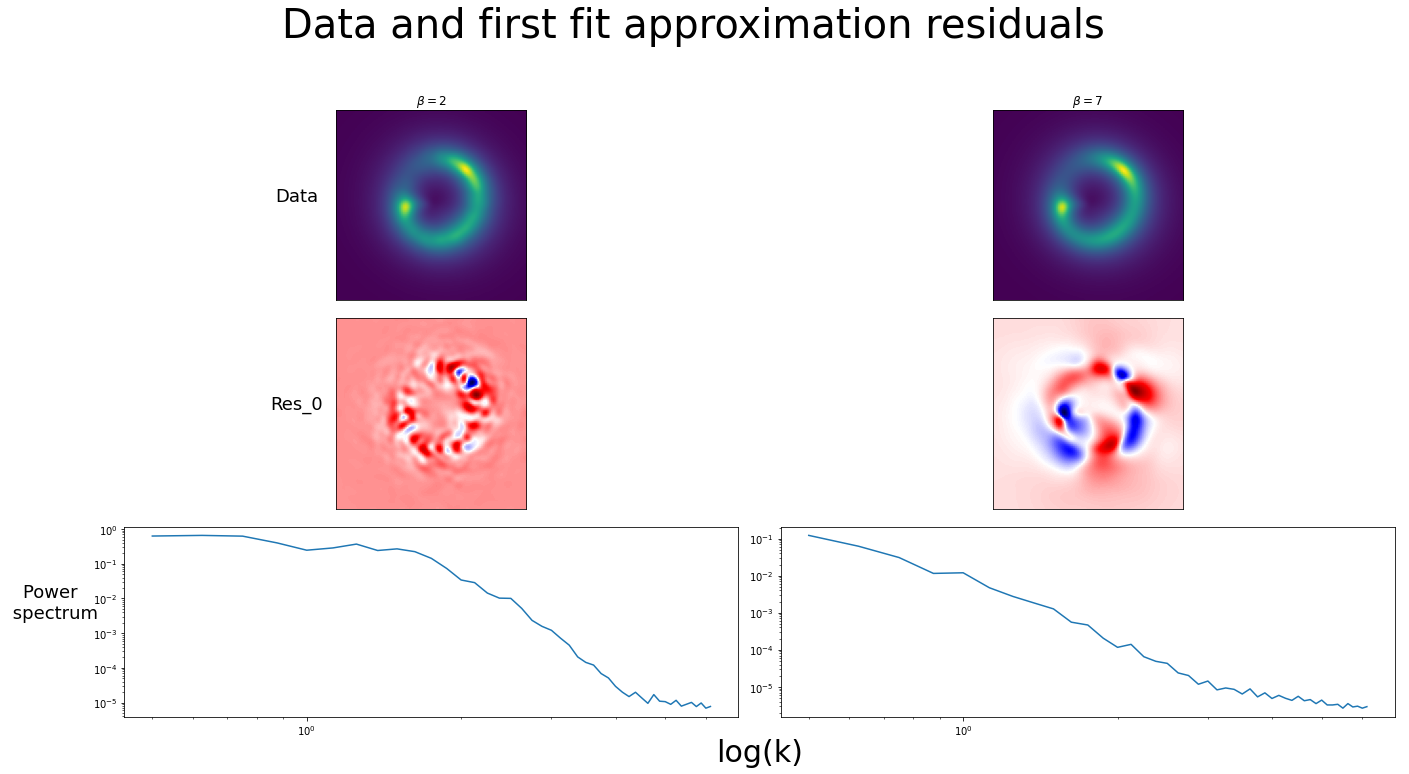

In [13]:
fig,ax=plt.subplots(3,2,figsize=(20,10))

#Data
for i in range(2):
  ax[0,i].imshow(data[i],origin='lower')
  ax[0,i].set_title(r'$\beta=$'+'{:.0f}'.format(Betas[i]))

ax[0,0].set_ylabel('Data',rotation=0.,labelpad=40,fontsize=FS)

for i in range(2):
  ax[1,i].imshow((data[i]-Fit_images_1[i]),origin='lower',cmap='seismic')

ax[1,0].set_ylabel('Res_0',rotation=0.,labelpad=40,fontsize=FS)

for i in range(2):
  for j in range(2):
      ax[i,j].set_xticks([])
      ax[i,j].set_yticks([])



for i in range(2):
  ax[2,i].plot(k,Res_0_Spectra[i])
  ax[2,i].set_xscale('log')
  ax[2,i].set_yscale('log')
  

ax[2,0].set_ylabel('Power \n spectrum',rotation=0.,labelpad=40,fontsize=FS)

fig.suptitle('Data and first fit approximation residuals',fontsize=40,y=1.1)


fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('log(k)',fontsize=30)

fig.tight_layout()
plt.show()


Everything's good.
Setup Betas=[2,7] and Variances=[1e-5,1e-4] results in pretty much same impact of GRF on the image. So the residuals are also of the same order of magnitude

## Simulate mock grid: $\psi(\vec{p}_{1})+\delta \psi(A_{0},\beta_{0},\phi^{m})$  

Fit it with smooth model to get residuals

model 2: $\psi(\vec{p_2})$  
$res^{i,j,m}=\delta \psi(A_{0},\beta_{0},\phi^{m})+\psi(\vec{p}_{1})-\psi(\vec{p_2})$

In this section we do not vary the amplitdue and power slope of GRF, cause we want to study impact of phase 

In [14]:
#Classes for generation of corresponding psi_1 images
GRF_classes_1=[]
for i in range(2):
    #Set corresponding source and unperturbed lens parameters
    GRF_classes_1+=[Potential_based_GRF_perturbed_lens(kwargs_lens_mass_array=kwargs_1[i]['kwargs_lens'],\
                                             kwargs_source_light_array=kwargs_1[i]['kwargs_source'])]
    #Set true GRF A,beta cause now we are concerned with phase only
    GRF_classes_1[i].Change_Power_Spectrum(Variance=GRF_Variances[i],Power_slope=Betas[i])

WARNING! sigma_b*f 0 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.
WARNING! sigma_b*f 0 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.


In [70]:
M=100
random_seeds=np.linspace(0,M-1,M,dtype=int)

'''
simulated_data=np.zeros((M,2,data.shape[-2],data.shape[-1]))

#Handle different scales
for i in tqdm(range(2)):
    for j,seed in tqdm(enumerate(random_seeds)):
      #Set seed to get different GRF phase
      GRF_classes_1[i].Lens_Source_model.random_seed=seed
      #Renew GRF realisation
      GRF_classes_1[i].Change_Power_Spectrum(Variance=GRF_Variances[i],Power_slope=Betas[i])
      #Draw simulated data
      simulated_data[j,i]=GRF_classes_1[i].get_lens_picture(picture_type='model')

np.save(Folder+'/Data/Phase_averaging_Pipeline_test/simulated_data_ijm_Beta=2_7_Var=1e-5-4.npy',simulated_data)

kwargs_2=[]
fisher_matrices_2=np.zeros((M,2,num_of_params,num_of_params))
Fit_images_2=np.zeros_like(simulated_data)
Res_ijm=np.zeros_like(simulated_data)

for i in tqdm(range(2)):
    kwargs_2_row=[]
    for j,seed in tqdm(enumerate(random_seeds)):
      parameters=get_parameters(GRF_class.Lens_Source_model)
      kwargs,fisher_matrix=fit_data(simulated_data[j,i],lens_image,parameters)
      kwargs_2_row+=[kwargs]
      fisher_matrices_2[j,i]=fisher_matrix


      lens_source_class=Lens_Source_model(kwargs_lens_mass_array=kwargs['kwargs_lens'],\
                                      kwargs_source_light_array=kwargs['kwargs_source'])
      Fit_images_2[j,i]=lens_source_class.get_lens_picture(picture_type='model')
    kwargs_2+=[kwargs_2_row]

Res_ijm=simulated_data-Fit_images_2
kwargs_2=np.array(kwargs_2).T

np.save(Folder+'/Data/Phase_averaging_Pipeline_test/Kwargs_2_Beta=2_7_Var=1e-5-4.npy',kwargs_2)
np.save(Folder+'/Data/Phase_averaging_Pipeline_test/Fisher_matrices_2_Beta=2_7_Var=1e-5-4.npy',fisher_matrices_2)
np.save(Folder+'/Data/Phase_averaging_Pipeline_test/Fit_images_2_Beta=2_7_Var=1e-5-4.npy',Fit_images_2)
np.save(Folder+'/Data/Phase_averaging_Pipeline_test/Res_ijm_Beta=2_7_Var=1e-5-4.npy',Res_ijm)
'''

"\nsimulated_data=np.zeros((M,2,data.shape[-2],data.shape[-1]))\n\n#Handle different scales\nfor i in tqdm(range(2)):\n    for j,seed in tqdm(enumerate(random_seeds)):\n      #Set seed to get different GRF phase\n      GRF_classes_1[i].Lens_Source_model.random_seed=seed\n      #Renew GRF realisation\n      GRF_classes_1[i].Change_Power_Spectrum(Variance=GRF_Variances[i],Power_slope=Betas[i])\n      #Draw simulated data\n      simulated_data[j,i]=GRF_classes_1[i].get_lens_picture(picture_type='model')\n\nnp.save(Folder+'/Data/Phase_averaging_Pipeline_test/simulated_data_ijm_Beta=2_7_Var=1e-5-4.npy',simulated_data)\n\nkwargs_2=[]\nfisher_matrices_2=np.zeros((M,2,num_of_params,num_of_params))\nFit_images_2=np.zeros_like(simulated_data)\nRes_ijm=np.zeros_like(simulated_data)\n\nfor i in tqdm(range(2)):\n    kwargs_2_row=[]\n    for j,seed in tqdm(enumerate(random_seeds)):\n      parameters=get_parameters(GRF_class.Lens_Source_model)\n      kwargs,fisher_matrix=fit_data(simulated_data[j,i],

In [71]:
simulated_data_ijm=np.load(Folder+'/Data/Phase_averaging_Pipeline_test/simulated_data_ijm_Beta=2_7_Var=1e-5-4.npy',allow_pickle=True)
kwargs_2=np.load(Folder+'/Data/Phase_averaging_Pipeline_test/Kwargs_2_Beta=2_7_Var=1e-5-4.npy',allow_pickle=True)
fisher_matrices_2=np.load(Folder+'/Data/Phase_averaging_Pipeline_test/Fisher_matrices_2_Beta=2_7_Var=1e-5-4.npy',allow_pickle=True)
Fit_images_2=np.load(Folder+'/Data/Phase_averaging_Pipeline_test/Fit_images_2_Beta=2_7_Var=1e-5-4.npy',allow_pickle=True)
Res_ijm=np.load(Folder+'/Data/Phase_averaging_Pipeline_test/Res_ijm_Beta=2_7_Var=1e-5-4.npy',allow_pickle=True)

## Hypothesis 1) weak dependence of model absorbtion function on phase $\phi^{m}$



One of the assumptions to be made is that model parameters aggravation should mostly depend on GRF's amplitude $A$ and power slope $\beta$, rather than on phase realisation $\phi$. So we say that impact of phase is small. Let's denote it as:

$\vec{p_1}=f(\vec{p},A_{0},\beta_{0}) + \delta f(\phi_{0})$   
$\vec{p_2}=f(f(\vec{p},A_{0},\beta_{0}) +\delta f(\phi_{0}),A^{i},\beta^{j})+ \delta f(\phi^{m})$

Let's take GRF with one particular impact on the lens and test whether fit parameters depend on phase

In [72]:
kwargs_deviation=np.full((M,2,num_of_params),parameters.kwargs2args(kwargs_true))


for i in range(M):
  for j in range(2):
    kwargs_deviation[i,j]=parameters.kwargs2args(kwargs_2[i,j])

parameter_names=deepcopy(parameters.symbols)

parameter_names[1:5]=['$e_1^{lens}$','$e_2^{lens}$','$x_{0}^{lens}}$', '$y_{0}^{lens}$']
parameter_names[-4:]=['$e_1^{source}$','$e_2^{source}$','$x_{0}^{source}}$', '$y_{0}^{source}$']

df_deviation_LS=pd.DataFrame(data=kwargs_deviation[:,0],columns=parameter_names)
df_deviation_HS=pd.DataFrame(data=kwargs_deviation[:,1],columns=parameter_names)

In [73]:
df_deviation=df_deviation_LS.melt()
df_deviation.loc[:,'Beta']=Betas[0]

temp=df_deviation_HS.melt()
temp.loc[:,'Beta']=Betas[1]
#Merge high scale and low scale splitting by 'Beta'
df_deviation=pd.concat([df_deviation,temp])
df_deviation.columns=['parameter','fit_value','Beta']

#Add true parameters
true_df=pd.DataFrame(parameters.kwargs2args(kwargs_true),columns=['true_value'])
true_df.loc[:,'parameter']=parameter_names
df_deviation=true_df.merge(df_deviation,on='parameter')

#get the realtive error
df_deviation['rel_error']=(df_deviation['true_value']-df_deviation['fit_value'])/df_deviation['true_value']

'''
pix_scl=GRF_class.Lens_Source_model.kwargs_pixel['transform_pix2angle'][0,0]
mask_x_lens=np.where(np.isinf(df_deviation['rel_error']))[0]
df_deviation.loc[np.where(np.isinf(df_deviation['rel_error']))[0],'rel_error']=0.'''

"\npix_scl=GRF_class.Lens_Source_model.kwargs_pixel['transform_pix2angle'][0,0]\nmask_x_lens=np.where(np.isinf(df_deviation['rel_error']))[0]\ndf_deviation.loc[np.where(np.isinf(df_deviation['rel_error']))[0],'rel_error']=0."

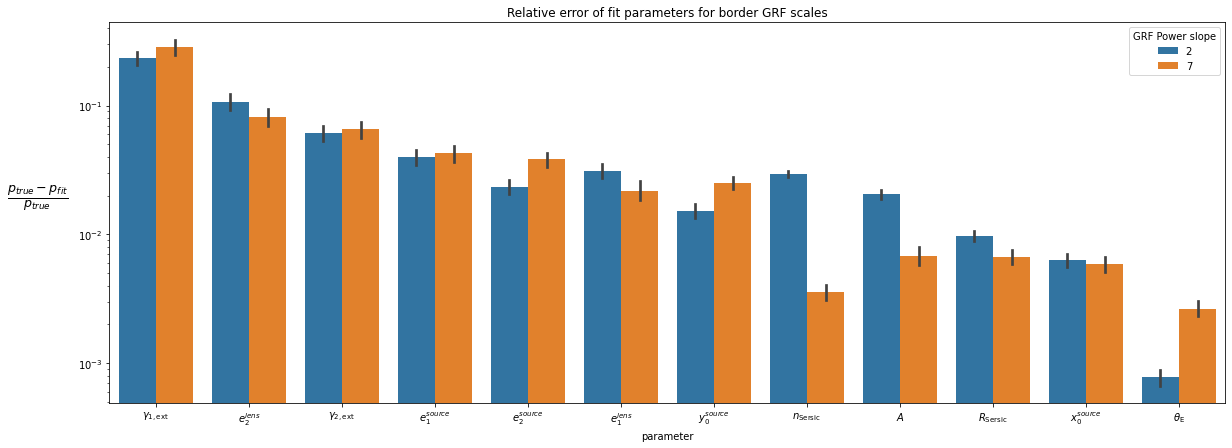

In [74]:
temp=df_deviation.drop(np.where(np.isinf(df_deviation['rel_error']))[0])
temp.loc[:,'rel_error']=np.abs(temp.loc[:,'rel_error'])

#Sort temp_df to get descending mean
mean_descending_ordering = temp.groupby('parameter').mean().sort_values('rel_error',ascending=False).index.to_numpy()
temp['parameter']=pd.Categorical(temp['parameter'], categories = mean_descending_ordering)
temp.sort_values('parameter',inplace=True)
temp.rename(columns={'Beta':'GRF Power slope'},inplace=True)

plt.figure(figsize=(20,7))
sns.barplot(data=temp,x='parameter',y='rel_error',hue='GRF Power slope')
plt.yscale('log')
plt.ylabel(r'$\frac{p_{true}-p_{fit}}{p_{true}}$',fontsize=FS,rotation=0,labelpad=40)
plt.title('Relative error of fit parameters for border GRF scales')
plt.show()

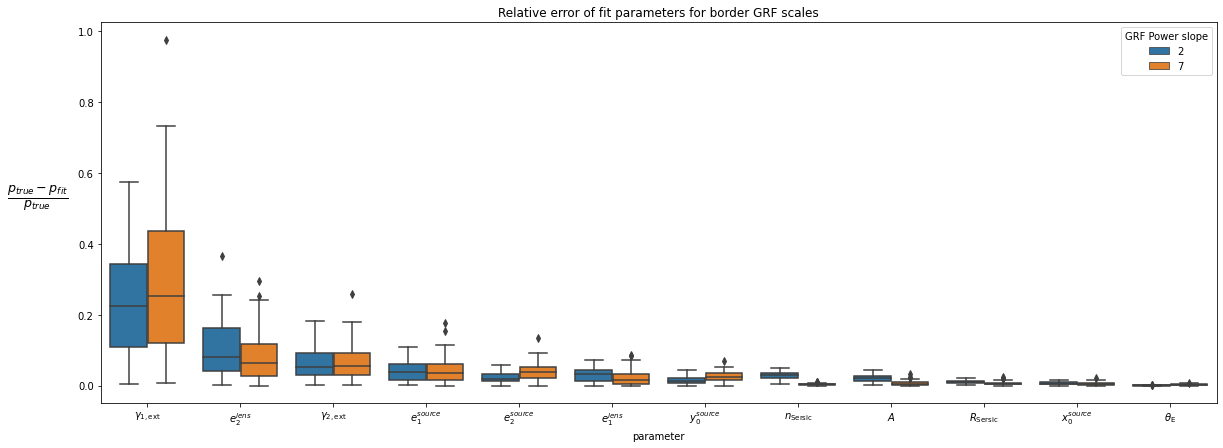

In [75]:
temp=df_deviation.drop(np.where(np.isinf(df_deviation['rel_error']))[0])
temp.loc[:,'rel_error']=np.abs(temp.loc[:,'rel_error'])

#Sort temp_df to get descending mean
mean_descending_ordering = temp.groupby('parameter').mean().sort_values('rel_error',ascending=False).index.to_numpy()
temp['parameter']=pd.Categorical(temp['parameter'], categories = mean_descending_ordering)
temp.sort_values('parameter',inplace=True)
temp.rename(columns={'Beta':'GRF Power slope'},inplace=True)

plt.figure(figsize=(20,7))
sns.boxplot(data=temp,x='parameter',y='rel_error',hue='GRF Power slope')
#plt.yscale('log')
plt.ylabel(r'$\frac{p_{true}-p_{fit}}{p_{true}}$',fontsize=FS,rotation=0,labelpad=40)
plt.title('Relative error of fit parameters for border GRF scales')
plt.show()

In [76]:
temp[['parameter','GRF Power slope','rel_error']].groupby(['parameter','GRF Power slope']).min().apply(np.log10)

rel_error
parameter             GRF Power slope           
$\gamma_{\rm 1, ext}$ 2                -2.228835
                      7                -2.171454
$e_2^{lens}$          2                -3.211219
                      7                -3.259103
$\gamma_{\rm 2, ext}$ 2                -2.970384
                      7                -2.895048
$e_1^{source}$        2                -2.881546
                      7                -4.184720
$e_2^{source}$        2                -4.153323
                      7                -3.605409
$e_1^{lens}$          2                -3.629663
                      7                -3.757314
$y_{0}^{source}$      2                -4.307271
                      7                -3.369304
$n_{\rm Sersic}$      2                -2.426645
                      7                -4.610367
$A$                   2                -2.661177
                      7                -4.038341
$R_{\rm Sersic}$      2                -3.042873
                      7                -3.635676
$x_{0}^{source}}$     2                -4.021915
                      7                -3.302549
$\theta_{\rm E}$      2                -5.569592
                      7                -4.665749

So phase variance adds 1 to 2 order of magnitude variance of parameter errors

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


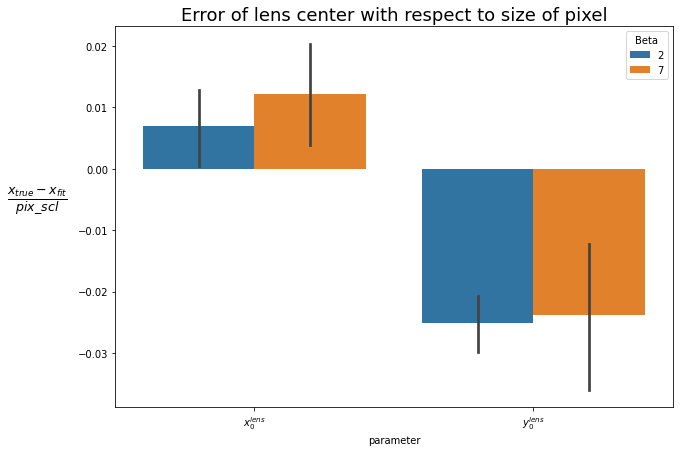

In [77]:
pix_scl=GRF_class.Lens_Source_model.kwargs_pixel['transform_pix2angle'][0,0]
mask_x_lens=np.isin(df_deviation.parameter,['$x_{0}^{lens}}$','$y_{0}^{lens}$'])
temp=df_deviation[mask_x_lens]
temp['rel_error']=(df_deviation['true_value']-df_deviation['fit_value'])/pix_scl


plt.figure(figsize=(10,7))
sns.barplot(data=temp,x='parameter',y='rel_error',hue='Beta')
plt.ylabel(r'$\frac{x_{true}-x_{fit}}{pix\_scl}$',fontsize=FS,rotation=0,labelpad=40)
plt.title('Error of lens center with respect to size of pixel',fontsize=FS)
plt.show()

## Hypothesis 2)Big enough number M of phase realisations $\phi^{m}$

We want to find such number of phases M that M power spectra would reflect general behaviour of the residuals independent of the particular phase realisation, so there are no degeneracies between lens and particular phase realisation. In math language it would be:  

$M: \quad  <PS\{res^{i,j,m}_{1}\}>_{m \in [0,M]} \quad \approx  \quad <PS\{res^{i,j,m}_{1}\}>_{m \in [0,\infty]}$

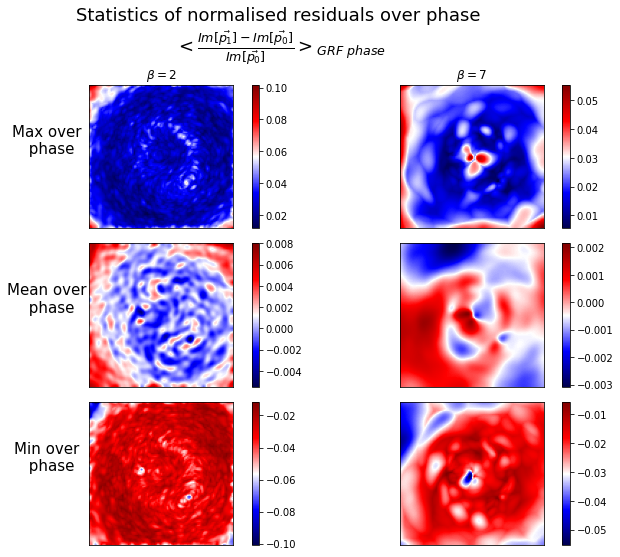

In [78]:
Normalised_residuals=Res_ijm/simulated_data_ijm

fig,ax=plt.subplots(3,2,figsize=(10,7))
cbar_loc=['left','right']
funcs=[np.max,np.mean,np.min]
funcs_meaning=['Max over \n phase','Mean over \n phase','Min over \n phase']
im_grid=[]

for j in range(3):
  im_row=[]
  for i in range(2):
    #Get max, mean, min in rows
    im=ax[j,i].imshow(np.apply_along_axis(funcs[j],axis=0,arr=Normalised_residuals[:,i]),cmap='seismic')
    im_row+=[im]

    ax[j,i].set_xticks([])
    ax[j,i].set_yticks([])

  im_grid+=[im_row]
  ax[j,0].set_ylabel(funcs_meaning[j],rotation=0.,labelpad=40,fontsize=15)

for i in range(2):
  ax[0,i].set_title(r'$\beta=$'+'{:.0f}'.format(Betas[i]))

for j in range(3):
  for i in range(2):
    fig.colorbar(im_grid[j][i],ax=ax[j,i],shrink=1)

#fig.colorbar(im_arr[1],ax=ax[1])
fig.suptitle('Statistics of normalised residuals over phase \n'+\
             r'$<\frac{Im[\vec{p_1}]-Im[\vec{p_0}]}{Im[\vec{p_0}]}>_{GRF \ phase}$',fontsize=18,y=1.1)
fig.tight_layout()

plt.show()

So here we considered max(Resid,axis=phase), mean(Resid,axis=phase), min(Resid,axis=phase).  

If we had significant degeneracies we would see structure of the degenerate regions on the images. The images are pretty much uniform except for the center. But the center is masked out anyway and not used in computing the residuals. Therefore we can state that from M=100 realisations of GRF phases lens is not degenerate with GRF's phase.

Interesting fact. When I used M=10 instead of M=100 I got more structured mean(residuals). Yet the peak values were still 0.008 and 0.002. Even though for beta=7 Variance was 1e-5 instead of 1e-4 like now

### Residuals Power spectra

In [88]:
Res_ijm_Spectra=np.zeros((M,2,Res_ijm.shape[-1]//2))
Res_smooth_ijm=Fit_images_1-Fit_images_2
Res_smooth_ijm_Spectra=np.zeros_like(Res_ijm_Spectra)

for i in tqdm(range(2)):
  for j in range(M):
    #Sometimes the value in k=0 can be very low. Actually its just a bias so we shouldn't be very concerned about it
    k,Res_ijm_Spectra[j,i]=compute_radial_spetrum(Res_ijm[j,i])
    k,Res_smooth_ijm_Spectra[j,i]=compute_radial_spetrum(Res_smooth_ijm[j,i])

min_k_index=np.where(np.isnan(Res_ijm_Spectra[0][0]))[0][-1]








  0%|          | 0/2 [00:00<?, ?it/s]






 50%|█████     | 1/2 [00:32<00:32, 32.78s/it]






100%|██████████| 2/2 [01:04<00:00, 32.48s/it]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in power


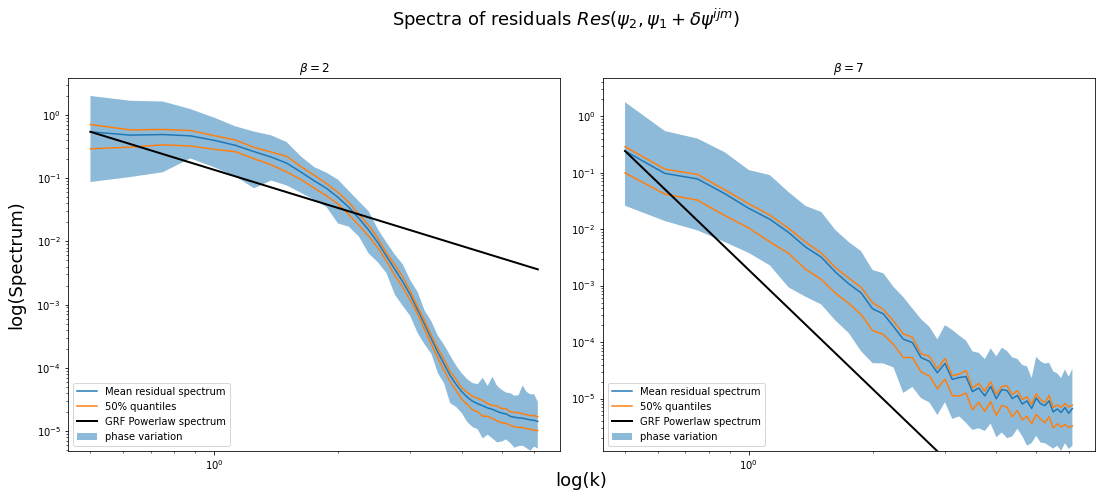

In [102]:
fig,ax=plt.subplots(1,2,figsize=(15,6))

array_len=Res_ijm_Spectra.shape[-1]
Power_spectrum=np.zeros_like(Res_ijm_Spectra[0])
mean_spectra=Res_ijm_Spectra.mean(axis=0)

for i in range(2):
  #Plot mean curve and border curves
  ax[i].plot(k,np.mean(Res_ijm_Spectra[:,i],axis=0),label='Mean residual spectrum',c='C0')
  ax[i].plot(k,np.quantile(Res_ijm_Spectra[:,i],0.25,axis=0),label='50% quantiles',c='C1')
  ax[i].plot(k,np.quantile(Res_ijm_Spectra[:,i],0.75,axis=0),c='C1')
  #Max and Min borders
  ax[i].fill_between(x=k,y1=Res_ijm_Spectra[:,i].max(axis=0),y2=Res_ijm_Spectra[:,i].min(axis=0),\
                     alpha=0.5,label='phase variation')

  #Plot GRF power spectrum
  #Start from k[1] to avoid divergence in zero
  Power_spectrum[i]=np.where(np.isnan(mean_spectra[i]),np.nan,np.power(k,-Betas[i]))
  #Normalize it to residual spectrum values
  Power_spectrum[i]*=mean_spectra[i,min_k_index+1]/Power_spectrum[i][min_k_index+1]
  ax[i].plot(k,Power_spectrum[i],linewidth=2,label='GRF Powerlaw spectrum',c='black')



ax[0].set_title(r'$\beta=2$')
ax[1].set_title(r'$\beta=7$')
for i in range(2):
  ax[i].set_yticks([])
  ax[i].set_yscale('log')
  ax[i].set_xscale('log')
  ax[i].legend(loc='lower left')
  ax[i].set_ylim(ymin=np.nanmin(Res_ijm_Spectra[:,i]))


fig.suptitle('Spectra of residuals '+r'$Res(\psi_2,\psi_1 +\delta \psi^{ijm})$',fontsize=FS,y=1.1)
fig.tight_layout()
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('log(k)',fontsize=FS)
plt.ylabel('log(Spectrum)',fontsize=FS,labelpad=20)
plt.show()

In [90]:
Res_smooth_ijm_Spectra.shape

(100, 2, 50)

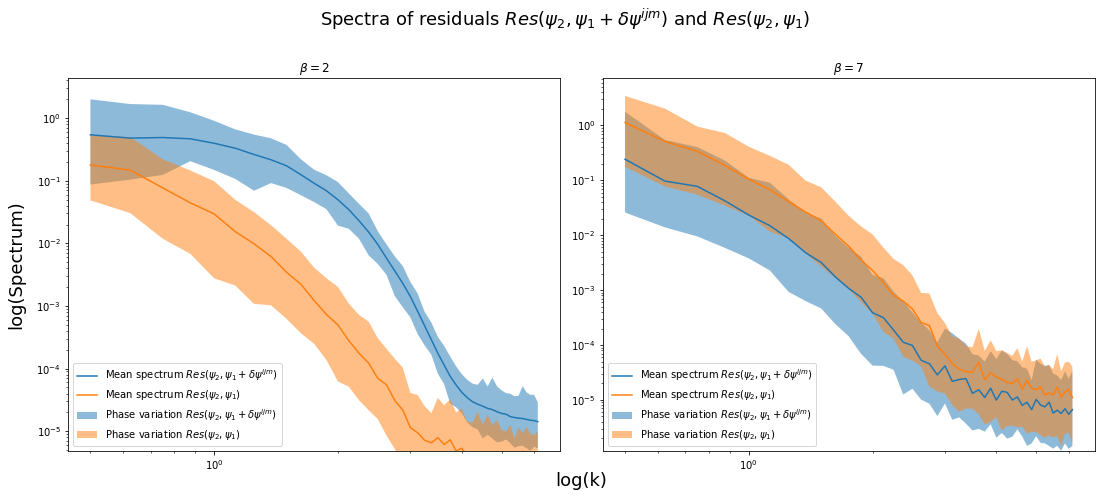

In [104]:
fig,ax=plt.subplots(1,2,figsize=(15,6))


array_len=Res_ijm_Spectra.shape[-1]
Power_spectrum=np.zeros_like(Res_ijm_Spectra[0])
mean_spectra=Res_ijm_Spectra.mean(axis=0)

for i in range(2):
  #Plot mean curve and border curves
  ax[i].plot(k,np.mean(Res_ijm_Spectra[:,i],axis=0),label='Mean spectrum '+r'$Res(\psi_2,\psi_1 +\delta \psi^{ijm})$',c='C0')

  ax[i].fill_between(x=k,y1=Res_ijm_Spectra[:,i].max(axis=0),y2=Res_ijm_Spectra[:,i].min(axis=0),\
                     alpha=0.5,label='Phase variation '+r'$Res(\psi_2,\psi_1 +\delta \psi^{ijm})$')

  ax[i].plot(k,np.mean(Res_smooth_ijm_Spectra[:,i],axis=0),label='Mean spectrum '+r'$Res(\psi_2,\psi_1)$',c='C1')

  ax[i].fill_between(x=k,y1=Res_smooth_ijm_Spectra[:,i].max(axis=0),y2=Res_smooth_ijm_Spectra[:,i].min(axis=0),\
                     alpha=0.5,label='Phase variation '+r'$Res(\psi_2,\psi_1)$')





ax[0].set_title(r'$\beta=2$')
ax[1].set_title(r'$\beta=7$')
for i in range(2):
  ax[i].set_yticks([])
  ax[i].set_yscale('log')
  ax[i].set_xscale('log')
  ax[i].legend(loc='lower left')
  ax[i].set_ylim(ymin=np.nanmin(Res_ijm_Spectra[:,i]))


fig.suptitle('Spectra of residuals '+r'$Res(\psi_2,\psi_1 +\delta \psi^{ijm})$'+' and '+r'$Res(\psi_2,\psi_1)$',fontsize=FS,y=1.1)
fig.tight_layout()
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('log(k)',fontsize=FS)
plt.ylabel('log(Spectrum)',fontsize=FS,labelpad=20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

Text(0.5, 1.0, 'Distributions of Power_Spectrum(k) depending on GRF phase')

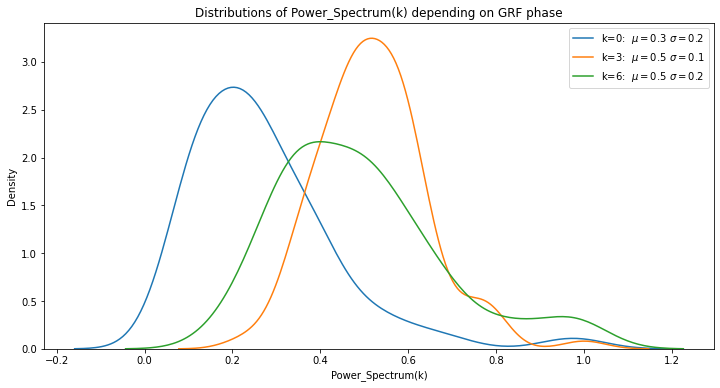

In [117]:
index=[min_k_index+1,25,49]
plt.figure(figsize=(12,6))
for i in range(3):
  q=deepcopy(Res_ijm_Spectra[:,0,index[i]])
  q/=q.max()
  sns.distplot(q,hist=False,label='k={:.0f}: '.format(k[index[i]])+r'$\ \mu={:.1f}$'.format(q.mean())+r'$\ \sigma={:.1f}$'.format(q.std()))

plt.xlabel('Power_Spectrum(k)')
plt.legend()
plt.title('Distributions of Power_Spectrum(k) depending on GRF phase')

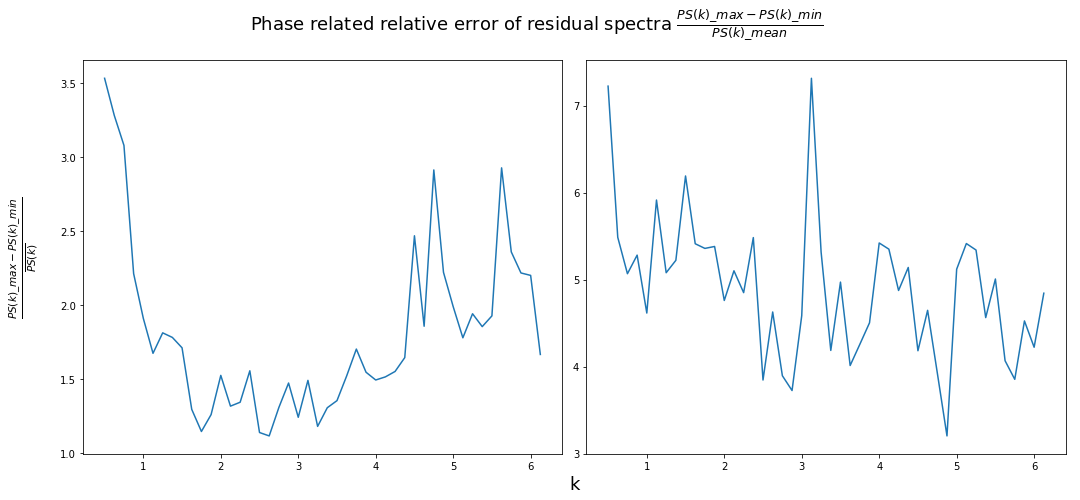

In [121]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
err=Res_ijm_Spectra.max(axis=0)-Res_ijm_Spectra.min(axis=0)
relative_error=err/mean_spectra

#Top row with spectrum
for i in range(2):
  ax[i].plot(k,relative_error[i])


  #ax[0,i].set_yticks([])
  #ax[i].set_yscale('log')
  #ax[i].set_xscale('log')

ax[0].set_ylabel(r'$\frac{PS(k)\_max-PS(k)\_min}{\overline{PS(k)}}$',fontsize=15,labelpad=20)

fig.suptitle('Phase related relative error of residual spectra '+r'$\frac{PS(k)\_max-PS(k)\_min}{PS(k)\_mean}$',fontsize=FS,y=1.1)
fig.tight_layout()
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('k',fontsize=FS)
plt.show()

In [ ]:
def bootstrap_CI_func_part(data,func,draw_len, nbr_draws=1000):
    res = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        #indices = np.random.randint(0, len(data), draw_len)
        indices=np.random.choice(np.arange(len(data)),size=draw_len,replace=False)
        data_tmp = data[indices] 
        q=func(data_tmp)
        res[n] = func(data_tmp)

    return res

In [ ]:
nbr_draws=1000
err_on_phase=np.zeros((M,2,nbr_draws))
selected_phases=np.linspace(1,M,M)

for scale in tqdm(range(2)):
  for i in range(M):
    err_on_phase[i,scale]=bootstrap_CI_func_part(Res_ijm_Spectra[:,scale], lambda x: np.nanmean(x.max(axis=0)-x.min(axis=0),axis=-1),draw_len=i+1)





  0%|          | 0/2 [00:00<?, ?it/s]



 50%|█████     | 1/2 [00:17<00:17, 17.68s/it]



100%|██████████| 2/2 [00:35<00:00, 17.55s/it]


In [ ]:
err_on_phase.shape

(100, 2, 1000)

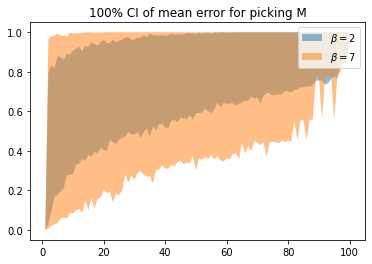

In [ ]:
max_err=err_on_phase.max(axis=-1)
min_err=err_on_phase.min(axis=-1)


plt.fill_between(selected_phases,max_err[:,0]/max_err[-1,0],min_err[:,0]/min_err[-1,0],label=r'$\beta=2$',alpha=0.5)
plt.fill_between(selected_phases,max_err[:,1]/max_err[-1,1],min_err[:,1]/min_err[-1,1],label=r'$\beta=7$',alpha=0.5)
plt.legend()
plt.title('100% CI of mean error for picking M')
plt.show()

Check from what M starts saturation of averaged spectrum properties.



So the error is always something like an order of magnitude.  

Anyway it would be good to make plot of error depending on M (number of phase realisations) and pick such M when it would start to get into saturation.




### Loss functions

$\mathcal{L}^{ij}=\frac{( \ PS\{res_{0}\} - <PS\{res^{i,j,m}>_m\} \ )^2}
{\sigma^2_{i,j}}$

$\mathcal{L}^{ij}=<\frac{( \ PS\{res_{0}\} - PS\{res^{i,j,m}\} \ )^2}
{\sigma^2_{i,j}}>_m$

$\mathcal{L}^{ij}=<\frac{| \ PS\{res_{0}\} - PS\{res^{i,j,m}\} \ |}
{\sigma^2_{i,j}}>_m$

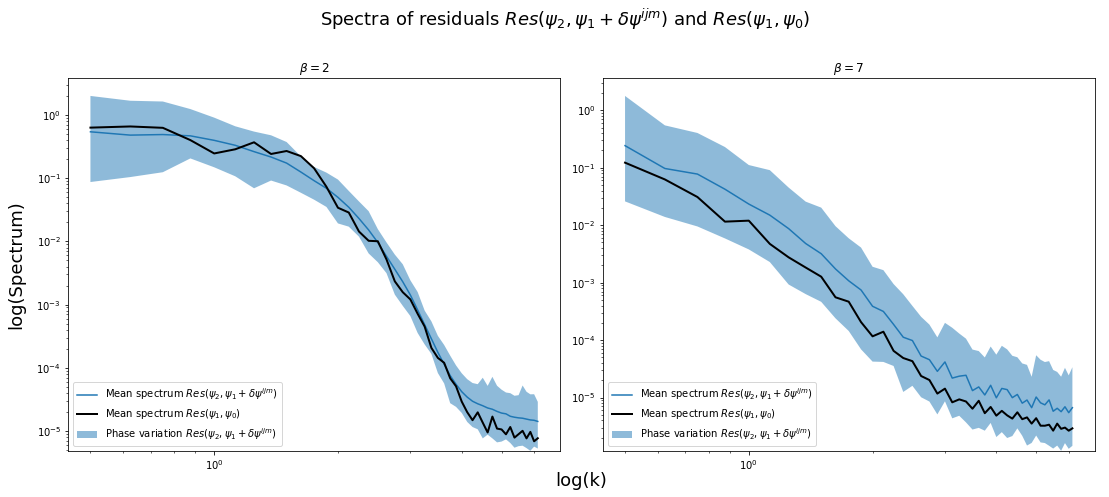

In [105]:
fig,ax=plt.subplots(1,2,figsize=(15,6))

array_len=Res_ijm_Spectra.shape[-1]
Power_spectrum=np.zeros_like(Res_ijm_Spectra[0])
mean_spectra=Res_ijm_Spectra.mean(axis=0)

for i in range(2):
  #Plot mean curve and border curves
  #ax[i].plot(k,mean_spectra[i],label='Average residual spectrum')
  ax[i].plot(k,np.mean(Res_ijm_Spectra[:,i],axis=0),label='Mean spectrum '+r'$Res(\psi_2,\psi_1 +\delta \psi^{ijm})$',c='C0')
  #ax[i].plot(k,np.quantile(Res_ijm_Spectra[:,i],0.25,axis=0),label='50% quantiles',c='C1')
  #ax[i].plot(k,np.quantile(Res_ijm_Spectra[:,i],0.75,axis=0),c='C1')
  #Max and Min borders
  ax[i].fill_between(x=k,y1=Res_ijm_Spectra[:,i].max(axis=0),y2=Res_ijm_Spectra[:,i].min(axis=0),\
                     alpha=0.5,label='Phase variation '+r'$Res(\psi_2,\psi_1 +\delta \psi^{ijm})$')

  ax[i].plot(k,Res_0_Spectra[i],linewidth=2,label='Mean spectrum '+r'$Res(\psi_1,\psi_0)$',c='black')



ax[0].set_title(r'$\beta=2$')
ax[1].set_title(r'$\beta=7$')
for i in range(2):
  ax[i].set_yticks([])
  ax[i].set_yscale('log')
  ax[i].set_xscale('log')
  ax[i].legend(loc='lower left')
  ax[i].set_ylim(ymin=np.nanmin(Res_ijm_Spectra[:,i]))


fig.suptitle('Spectra of residuals '+r'$Res(\psi_2,\psi_1 +\delta \psi^{ijm})$'+' and '+r'$Res(\psi_1,\psi_0)$',fontsize=FS,y=1.1)
fig.tight_layout()
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('log(k)',fontsize=FS)
plt.ylabel('log(Spectrum)',fontsize=FS,labelpad=20)
plt.show()

In [106]:
def internal_mean_SE(data,fit_samples,Poisson_err=False):
  mean_fit=fit_samples.mean(axis=0)
  if Poisson_err:
    return np.nanmean(np.power((data-mean_fit)/mean_fit,2),axis=-1)
  else:
    return np.nanmean(np.power(data-mean_fit,2),axis=-1)

def external_mean_SE(data,fit_samples,Poisson_err=False):
  if Poisson_err:
    return np.nanmean(np.power((data-fit_samples)/fit_samples,2),axis=(0,-1))
  else:
    return np.nanmean(np.power((data-fit_samples),2),axis=(0,-1))


def external_mean_AE(data,fit_samples,Poisson_err=False):
  if Poisson_err:
    Losses=np.abs((data-fit_samples)/fit_samples)
    return np.nanmean(Losses,axis=(0,-1))
  else: 
    Losses=np.abs((data-fit_samples))
    return np.nanmean(Losses,axis=(0,-1))

def bootstrap_CI_func_shaped(data,func,draw_len,nbr_draws=1000):
    res = np.zeros((data.shape[1],nbr_draws))
    data = np.array(data)

    for n in range(nbr_draws):
        #indices = np.random.randint(0, len(data), draw_len)
        indices=np.random.choice(np.arange(len(data)),size=draw_len,replace=False)
        data_tmp = data[indices] 
        q=func(data_tmp)
        res[:,n] = func(data_tmp)

    return res

def relative_loss_variation(losses_on_phase):
  max=losses_on_phase.max(axis=-1)
  min=losses_on_phase.min(axis=-1)

  #min[-1]=max[-1]=Loss(M=100)
  relative_varitation=(max-min)/min[-1]
  return relative_varitation

In [107]:
nbr_draws=1000
int_MSE_losses_on_phase=np.zeros((M,2,nbr_draws))
ext_MSE_losses_on_phase=np.zeros((M,2,nbr_draws))
ext_MAE_losses_on_phase=np.zeros((M,2,nbr_draws))


selected_phases=np.linspace(1,M,M)

for i in range(M):
  int_MSE_losses_on_phase[i]=bootstrap_CI_func_shaped(Res_ijm_Spectra, lambda x: internal_mean_SE(Res_0_Spectra,x,Poisson_err=True),draw_len=i+1)
  ext_MSE_losses_on_phase[i]=bootstrap_CI_func_shaped(Res_ijm_Spectra, lambda x: external_mean_SE(Res_0_Spectra,x,Poisson_err=True),draw_len=i+1)
  ext_MAE_losses_on_phase[i]=bootstrap_CI_func_shaped(Res_ijm_Spectra, lambda x: external_mean_AE(Res_0_Spectra,x,Poisson_err=True),draw_len=i+1)

In [108]:
int_MSE_loss_var=relative_loss_variation(int_MSE_losses_on_phase)
ext_MSE_loss_var=relative_loss_variation(ext_MSE_losses_on_phase)
ext_MAE_loss_var=relative_loss_variation(ext_MAE_losses_on_phase)

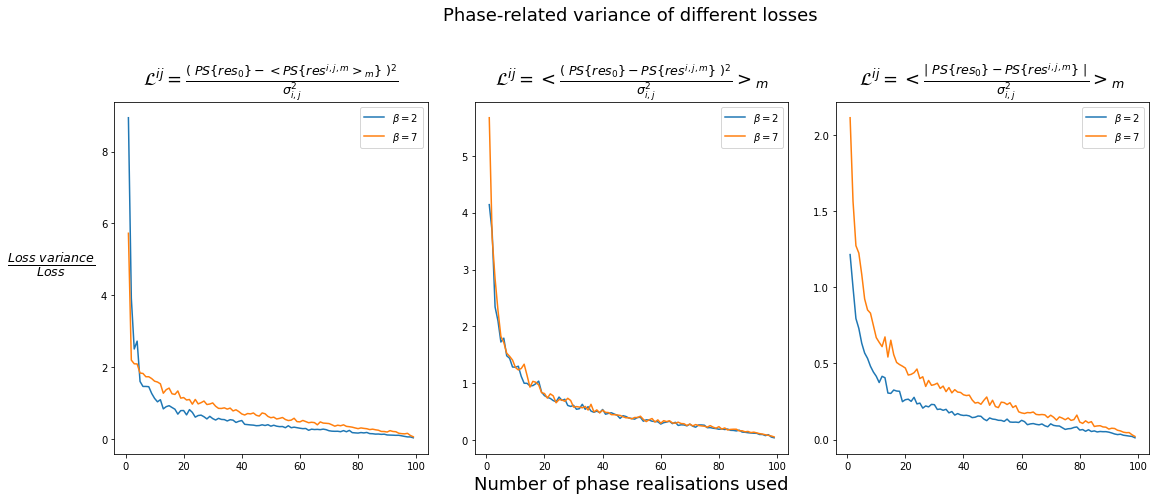

In [109]:
fig,ax=plt.subplots(1,3,figsize=(15,6))
loss_vars=np.array([int_MSE_loss_var,ext_MSE_loss_var,ext_MAE_loss_var])
loss_names=[r'$\mathcal{L}^{ij}=\frac{( \ PS\{res_{0}\} - <PS\{res^{i,j,m}>_m\} \ )^2}{\sigma^2_{i,j}}$',\
            r'$\mathcal{L}^{ij}=<\frac{( \ PS\{res_{0}\} - PS\{res^{i,j,m}\} \ )^2}{\sigma^2_{i,j}}>_m$',\
            r'$\mathcal{L}^{ij}=<\frac{| \ PS\{res_{0}\} - PS\{res^{i,j,m}\} \ |}{\sigma^2_{i,j}}>_m$']

for j,loss_var in enumerate(loss_vars):
  ax[j].set_title(loss_names[j],fontsize=FS)

  #ax[j].set_ylim(top=loss_vars.max(),bottom=loss_vars[:,:-1,:].min())

  #ax[j].set_yscale('log')
  #ax[j].set_xscale('log')
  
  for i in range(2):
    ax[j].plot(selected_phases[:-1],loss_var[:-1,i],label=r'$\beta=$'+'{:.0f}'.format(Betas[i]))
  ax[j].legend()
    
  
#ax[0].set_ylabel(r'$\frac{Loss \ variance}{Loss}$',labelpad=40,rotation=0,fontsize=FS)
#ax[0].set_xlabel('Number of phase realisations used')

fig.suptitle('Phase-related variance of different losses',fontsize=FS,y=1.1)
fig.tight_layout()

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Number of phase realisations used',fontsize=FS)
plt.ylabel(r'$\frac{Loss \ variance}{Loss}$',labelpad=40,rotation=0,fontsize=FS)
plt.show()

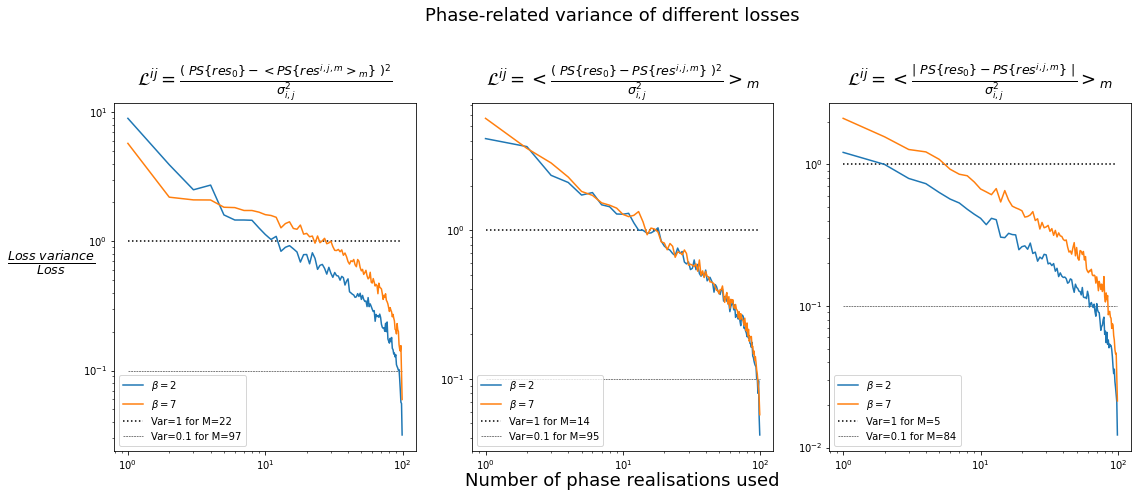

In [110]:
fig,ax=plt.subplots(1,3,figsize=(15,6))
loss_vars=np.array([int_MSE_loss_var,ext_MSE_loss_var,ext_MAE_loss_var])
loss_names=[r'$\mathcal{L}^{ij}=\frac{( \ PS\{res_{0}\} - <PS\{res^{i,j,m}>_m\} \ )^2}{\sigma^2_{i,j}}$',\
            r'$\mathcal{L}^{ij}=<\frac{( \ PS\{res_{0}\} - PS\{res^{i,j,m}\} \ )^2}{\sigma^2_{i,j}}>_m$',\
            r'$\mathcal{L}^{ij}=<\frac{| \ PS\{res_{0}\} - PS\{res^{i,j,m}\} \ |}{\sigma^2_{i,j}}>_m$']

for j,loss_var in enumerate(loss_vars):
  ax[j].set_title(loss_names[j],fontsize=FS)

  #ax[j].set_ylim(top=loss_vars.max(),bottom=loss_vars[:,:-1,:].min())
  ax[j].set_yscale('log')
  ax[j].set_xscale('log')

  unity_var_index=np.where(loss_var[:-1,i]<1)[0][0]
  ax[j].hlines(1,selected_phases[0],selected_phases[-2],linestyle='dotted',label='Var={:.0f} for M={:.0f}'.format(1,unity_var_index))

  decimal_var_index=np.where(loss_var[:-1,i]<1e-1)[0][0]
  ax[j].hlines(1e-1,selected_phases[0],selected_phases[-2],linestyle='dashed',linewidth=0.5,label='Var={:.1f} for M={:.0f}'.format(1e-1,decimal_var_index))
  for i in range(2):
    ax[j].plot(selected_phases[:-1],loss_var[:-1,i],label=r'$\beta=$'+'{:.0f}'.format(Betas[i]))
  ax[j].legend(loc='lower left')
    
  
#ax[0].set_ylabel(r'$\frac{Loss \ variance}{Loss}$',labelpad=40,rotation=0,fontsize=FS)
#ax[0].set_xlabel('Number of phase realisations used')

fig.suptitle('Phase-related variance of different losses',fontsize=FS,y=1.1)
fig.tight_layout()

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Number of phase realisations used',fontsize=FS)
plt.ylabel(r'$\frac{Loss \ variance}{Loss}$',labelpad=40,rotation=0,fontsize=FS)
plt.show()

Compare PS of residuals of smooth models with true residuals

Probably it also makes sense to use loss in a form of chi_sq, specifically we define Power spectrum averaged over phases, and define its variance that refers to phase:  
$PS\{res^{i,j}_{1}\}=<PS\{res^{i,j,m}_{1}\}>_m$  
$\sigma^2_{i,j}=\sum_{m}  (PS\{res^{i,j,m}_{1}\} - PS\{res^{i,j}_{1}\})^2 $ 

$\mathcal{L}^{ij}=\frac{( \ PS\{res_{0}\} - PS\{res^{i,j}_{1}\} \ )^2}
{\sigma^2_{i,j}}$